In [61]:
import sys
sys.path.append("../")

In [62]:
%load_ext autoreload
%autoreload 2

from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ, RBF, Linear

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
import pickle

import high_dim_power as hd

import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = "cm"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
tf.random.set_seed(1)

DELTA = 10. # 1. # 0.1

BANDWIDTH_POWER = 1.

STATISTIC = "mmd" # "ksd" # 

KERNEL = Linear # RBF # 

DIR = "../res/high_dim"
SUFFIX = f"delta{DELTA}_r{BANDWIDTH_POWER}_{STATISTIC}_{KERNEL.__name__}"
EXTRA = "" # "_sqrt" # "_quad" #  

In [194]:
dims = [1, 2, 4, 25, 50, 100, 250, 500, 1000, 2000]
ns = [50] * len(dims)

if EXTRA == "_quad":
    dims = [1, 2, 4, 25, 50, 100, 250, 500, 1000]
    ns = [max(2, int(d**1.2)) for d in dims]

elif EXTRA == "_sqrt":
    dims = [1, 2, 4, 25, 50, 100, 250, 500, 1000, 2000]
    ns = [max(2, int(d**0.5)) for d in dims]

elif EXTRA == "_sqrt_large":
    dims = [1, 2, 4, 25, 50, 100, 250, 500, 1000, 2000]
    ns = [int(50 * d**0.5) for d in dims]


# Load results

In [195]:
# load analytical res
res_analytical_save = pd.read_csv(
    f"{DIR}/res_analytical_{SUFFIX}.csv",
)
# res_analytical = {c: res_analytical_save[c].to_list() for c in res_analytical_save.columns}
# dims = list(res_analytical["dim"])
res_analytical = res_analytical_save.set_index("dim", drop=False)

In [196]:
# load empirical results
# high dim
stats_res_list = pickle.load(
    open(f"{DIR}/stats_res_rep_{SUFFIX}{EXTRA}.p", "rb"),
)

In [136]:
# load empirical results
# low dim
stats_res_list_ld = pickle.load(
    open(f"{DIR}/stats_res_rep_{SUFFIX}_ld.p", "rb"),
)

dims_ld = list(stats_res_list_ld[0].keys())
ns_ld = [1000] * len(dims_ld) # TODO change according to experiment

# Initialise result classes

In [181]:
# high dim
d = dims[-1]
print("dim:", d)
ts = res_analytical.loc[d, "expectation"] * np.linspace(-3., 4., 101)

hd_limits_rep_dims = hd.LimitDistExperimentRepeatedMultiDims(
    empirical_vals_dims_list=stats_res_list,
    res_analytical=res_analytical,
    dims=dims,
    ns=ns,
    ts=ts,
)

dim: 1000


In [46]:
# low dim
d_ld = 2
print("dim:", d_ld)
ts_ld = res_analytical.loc[d_ld, "expectation"] * np.linspace(0.75, 1.25, 101)

hd_limits_rep_dims_ld = hd.LimitDistExperimentRepeatedMultiDims(
    empirical_vals_dims_list=stats_res_list_ld,
    res_analytical=res_analytical,
    dims=dims_ld,
    ns=ns_ld,
    ts=ts_ld,
)

dim: 2


## Vary both sample size and dim

In [197]:
# compute CDFs
cdf_rep = hd_limits_rep_dims.run(dim=d)

cdf_rep.replace({
    "probs": "Exceeding prob", 
    "cond": "Classic", 
    "full": "High dim Gaussian",
    "mm_full": "High dim Gamma",
}, inplace=True)

In [27]:
# low dim
# compute CDFs
cdf_rep_ld = hd_limits_rep_dims_ld.run(dim=d_ld)

cdf_rep_ld.replace({
    "probs": "Exceeding prob", 
    "cond": "Classic", 
    "full": "High dim Gaussian",
    "mm_full": "High dim Gamma",
}, inplace=True)

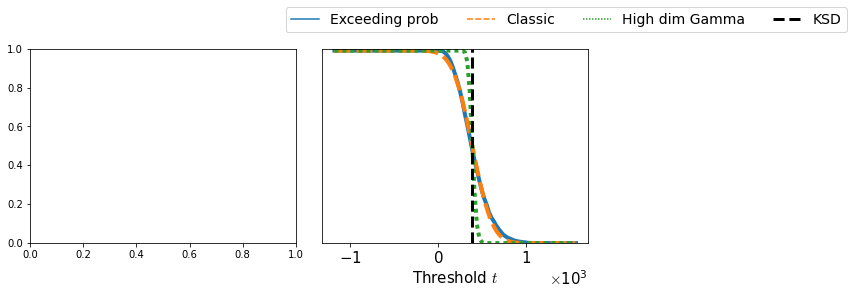

In [115]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# sns.lineplot(
#     ax=axes[0],
#     data=cdf_rep_ld.loc[
#         cdf_rep_ld.name.isin(["Exceeding prob", "Classic", "High dim Gamma"])
#     ], 
#     x="ts", 
#     y="value", 
#     hue="name",
#     style="name",
#     linewidth=4,
# )
# # statistic expectation
# axes[0].axvline(
#     res_analytical.loc[d_ld, "expectation"], color="k", linestyle="--", label="KSD", linewidth=3,
# )

# axes[0].set_xlabel("Threshold $t$", fontsize=15)
# axes[0].set_ylabel("Probability", fontsize=15)
# axes[0].set_ylim(0., 1.01)
# axes[0].tick_params(labelsize=15)
# axes[0].legend(
#     fontsize=14, bbox_to_anchor=(2., 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
# )

sns.lineplot(
    ax=axes[1],
    data=cdf_rep.loc[
        cdf_rep.name.isin(["Exceeding prob", "Classic", "High dim Gamma"])
    ], 
    x="ts", 
    y="value", 
    hue="name",
    style="name",
    linewidth=4,
)
# statistic expectation
axes[1].axvline(
    res_analytical.loc[d, "expectation"], color="k", linestyle="--", label="KSD", linewidth=3,
)

axes[1].set_xlabel("Threshold $t$", fontsize=15)
axes[1].set_ylim(0., 1.01)
axes[1].tick_params(labelsize=15)
axes[1].ticklabel_format(style="sci", axis="x", scilimits=(0, 0), useMathText=True)
axes[1].xaxis.get_offset_text().set_fontsize(15)
axes[1].get_yaxis().set_visible(False)
# axes[1].legend([],[], frameon=False)
axes[1].legend(
    fontsize=14, bbox_to_anchor=(2., 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
)
     
plt.subplots_adjust(
    top=.8,
    wspace=0.1,
)

# plt.savefig(f"../figs/high_dim/power_{STATISTIC}_{KERNEL.__name__}.pdf", bbox_inches="tight")

## test of Gaussianity

In [398]:
# from src.mmd.mmd import MMD

# def ff(
#     d: int,
#     bandwidth_order: float,
#     npop: int=4000,
#     delta: float=2.,
# ):
    
#     kernel = Linear(sigma_sq=2.*d**bandwidth_order)
#     target_dist, sample_dist = hd.generate_target_proposal(d, delta)
#     X = sample_dist.sample((npop,))
    
#     Y = target_dist.sample((npop,))
    
#     # initialise MMD
#     metric_fn = MMD(kernel=kernel)
    
#     mmd_m3 = metric_fn.m3_test(X, Y).numpy()
#     return mmd_m3
    
# mmd_m3 = ff(d=2, bandwidth_order=1, npop=4000, delta=2.)

In [ ]:
# mmd_m3

## debug: mean does not match average

In [165]:
res_analytical.loc[d_ld, "expectation"]

0.38608322

In [166]:
np.mean(np.concatenate([l[d_ld] for l in stats_res_list_ld]))

0.39379808

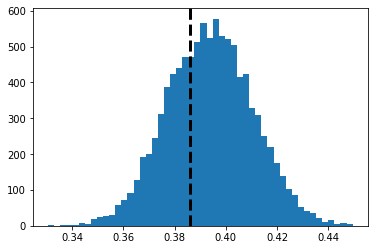

In [158]:
plt.hist(np.concatenate([l[d_ld] for l in stats_res_list_ld]), bins=50)
plt.axvline(
    res_analytical.loc[d_ld, "expectation"], color="k", linestyle="--", label="KSD", linewidth=3,
)

## distance

In [127]:
# compute distances
dist_rep = hd_limits_rep_dims.compute_distance(size=100000)

dist_rep.replace({
    "probs": "Exceeding prob", 
    "cond": "Classic", 
    "full": "High dim Gaussian",
    "mm_full": "High dim Gamma",
}, inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.49s/it]


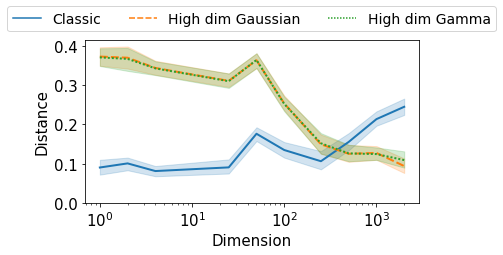

In [255]:
# mmd
figs, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))

sns.lineplot(
    ax=axes,
    data=dist_rep.loc[dist_rep.name.isin(["Classic", "High dim Gamma", "High dim Gaussian"])], 
    x="dim", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
)

axes.set_xlabel("Dimension", fontsize=15)
axes.set_ylabel("Distance", fontsize=15)
axes.set_ylim(bottom=0.)
axes.set_xscale("log")
axes.tick_params(labelsize=15)
axes.legend(
    fontsize=14, bbox_to_anchor=(1.25, 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
)
plt.savefig(f"../figs/high_dim/dist_{STATISTIC}_{KERNEL.__name__}.pdf", bbox_inches="tight")

In [256]:
import scipy.stats as spy_stats

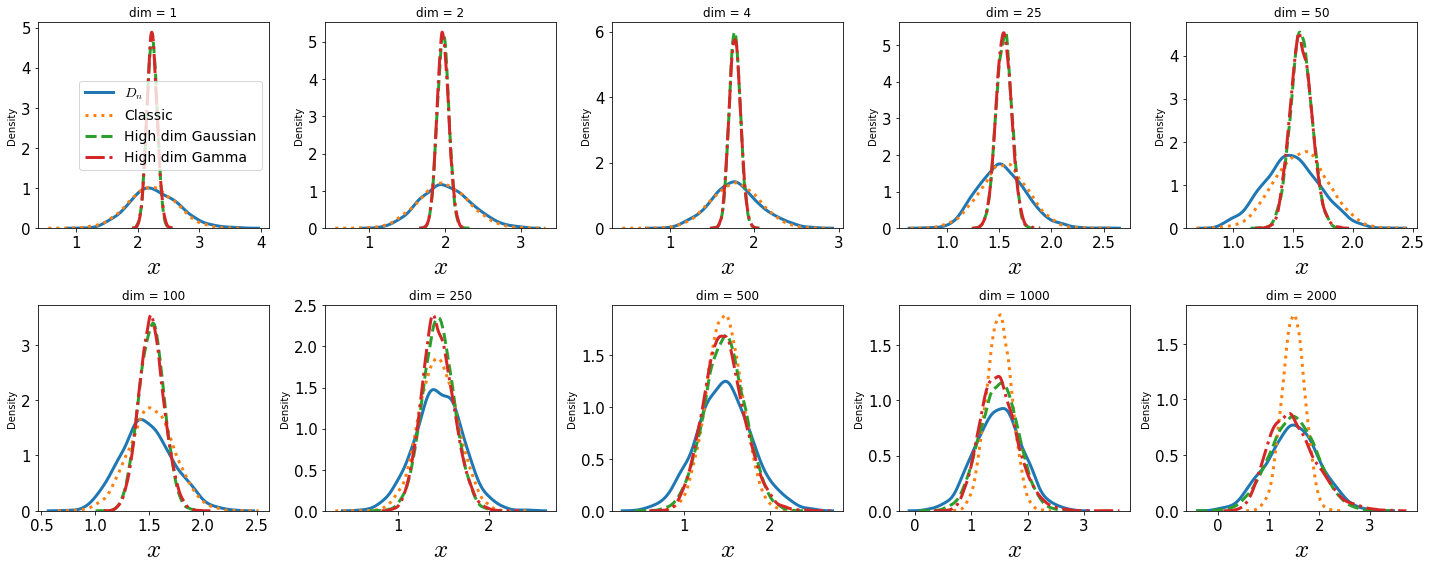

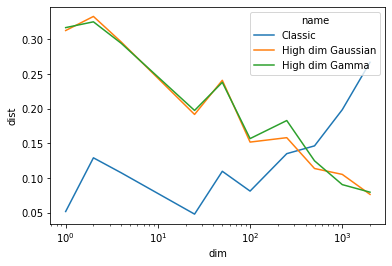

In [267]:
figs, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

legend_labels = {
    "Dn": "$D_n$", "Classic": "Classic", "High dim Gaussian": "High dim Gaussian", 
    "High dim Gamma": "High dim Gamma",
}
lstyles = ["solid", "dotted", "dashed", "dashdot"]
dd_list = []

for i, ax in enumerate(axes.flat):
    samples_res = hd_limits_rep_dims.get_exp(dims[i]).sample_all_limits(size=1000)
    samples_res.replace({
        "probs": "Dn", 
        "cond": "Classic", 
        "full": "High dim Gaussian",
        "mm_full": "High dim Gamma",
    }, inplace=True)
    
    show_legend = True if i == 0 else False
    for j, (n, l) in enumerate(legend_labels.items()):
        sns.kdeplot(
            ax=ax,
            data=samples_res.loc[samples_res.name == n],
            x="x",
            linewidth=3,
            common_norm=False,
            label=l,
            linestyle=lstyles[j],
            legend=show_legend,
        )
        
        # compute dist
        if n != "Dn":
            dn = samples_res.loc[(samples_res.seed == 0) & (samples_res.name == "Dn"), "x"].to_numpy()
            lim_x = samples_res.loc[(samples_res.seed == 0) & (samples_res.name == n), "x"].to_numpy()
            dist = spy_stats.energy_distance(dn, lim_x)
            dd_list.append([dist, n, dims[i]])

    ax.set_title(f"dim = {dims[i]}")
    ax.set_xlabel("$x$", fontsize=25)
    ax.tick_params(labelsize=15)
    if show_legend:
        ax.legend(fontsize=14)
    
plt.tight_layout()
plt.show()

# plot dist
dd_df = pd.DataFrame(dd_list, columns=["dist", "name", "dim"])
sns.lineplot(data=dd_df, x="dim", y="dist", hue="name")
plt.xscale("log")
plt.show()

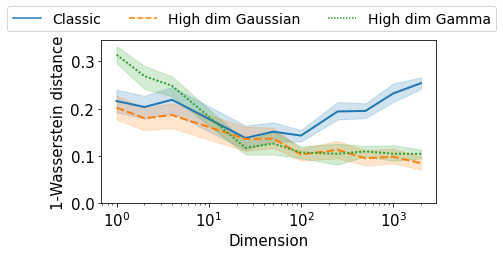

In [52]:
# sqrt inceasing n
figs, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))

sns.lineplot(
    ax=axes,
    data=dist_rep.loc[dist_rep.name.isin(["Classic", "High dim Gamma", "High dim Gaussian"])], 
    x="dim", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
)

axes.set_xlabel("Dimension", fontsize=15)
axes.set_ylabel("1-Wasserstein distance", fontsize=15)
axes.set_ylim(bottom=0.)
axes.set_xscale("log")
axes.tick_params(labelsize=15)
axes.legend(
    fontsize=14, bbox_to_anchor=(1.2, 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
)
# plt.savefig(f"../figs/high_dim/dist_{STATISTIC}_{KERNEL.__name__}.pdf", bbox_inches="tight")

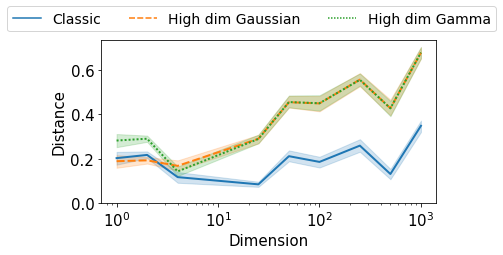

In [28]:
# quadractic increasing n
figs, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))

sns.lineplot(
    ax=axes,
    data=dist_rep.loc[dist_rep.name.isin(["Classic", "High dim Gamma", "High dim Gaussian"])], 
    x="dim", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
)

axes.set_xlabel("Dimension", fontsize=15)
axes.set_ylabel("Distance", fontsize=15)
axes.set_ylim(bottom=0.)
axes.set_xscale("log")
axes.tick_params(labelsize=15)
axes.legend(
    fontsize=14, bbox_to_anchor=(1.2, 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
)
# plt.savefig(f"../figs/high_dim/dist_{STATISTIC}_{KERNEL.__name__}.pdf", bbox_inches="tight")

## CDF and density plots

In [198]:
samples_res = hd_limits_rep_dims.get_exp(d).sample_all_limits(size=1000)

using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit
using chi-sq limit


In [199]:
samples_res.replace({
    "probs": "Dn", 
    "cond": "Classic", 
    "full": "High dim Gaussian",
    "mm_full": "High dim Gamma",
}, inplace=True)

In [201]:
samples_res_ld = hd_limits_rep_dims_ld.get_exp(d_ld).sample_all_limits(size=1000)

In [379]:
samples_res_ld.replace({
    "probs": "Dn", 
    "cond": "Classic", 
    "full": "High dim Gaussian",
    "mm_full": "High dim Gamma",
}, inplace=True)

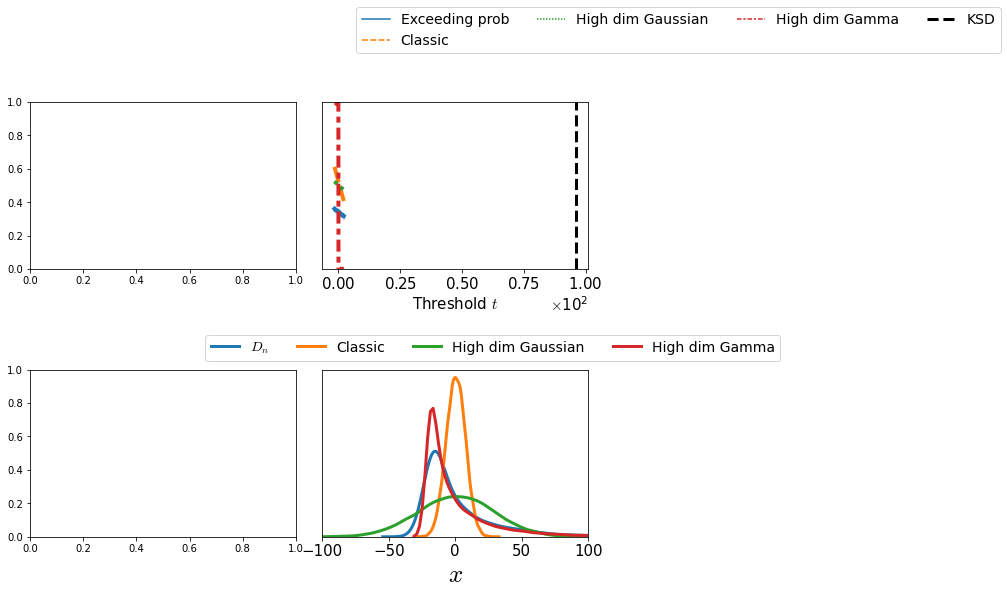

In [202]:
figs, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# # 1.ecdf plots
# sns.lineplot(
#     ax=axes[0][0],
#     data=cdf_rep_ld.loc[
#         cdf_rep_ld.name.isin(["Exceeding prob", "Classic", "High dim Gaussian"])
#     ], 
#     x="ts", 
#     y="value", 
#     hue="name",
#     style="name",
#     linewidth=4,
# )
# # statistic expectation
# axes[0][0].axvline(
#     res_analytical.loc[d_ld, "expectation"], color="k", linestyle="--", label="KSD", linewidth=3,
# )

# axes[0][0].set_xlabel("Threshold $t$", fontsize=15)
# axes[0][0].set_ylabel("Probability", fontsize=15)
# axes[0][0].set_ylim(0., 1.01)
# axes[0][0].tick_params(labelsize=15)
# axes[0][0].legend(
#     fontsize=14, bbox_to_anchor=(2.15, 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
# )

sns.lineplot(
    ax=axes[0][1],
    data=cdf_rep.loc[
        cdf_rep.name.isin(["Exceeding prob", "Classic", "High dim Gaussian", "High dim Gamma"])
    ], 
    x="ts", 
    y="value", 
    hue="name",
    style="name",
    linewidth=4,
)
# statistic expectation
axes[0][1].axvline(
    res_analytical.loc[d, "expectation"], color="k", linestyle="--", label="KSD", linewidth=3,
)

axes[0][1].set_xlabel("Threshold $t$", fontsize=15)
axes[0][1].set_ylim(0., 1.01)
axes[0][1].tick_params(labelsize=15)
axes[0][1].ticklabel_format(style="sci", axis="x", scilimits=(0, 0), useMathText=True)
axes[0][1].xaxis.get_offset_text().set_fontsize(15)
axes[0][1].get_yaxis().set_visible(False)
# axes[0][1].legend([],[], frameon=False)
axes[0][1].legend(
    fontsize=14, bbox_to_anchor=(0.1, 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
)

# 2. density plots
legend_labels = {
    "Dn": "$D_n$", "Classic": "Classic", "High dim Gaussian": "High dim Gaussian", 
    "High dim Gamma": "High dim Gamma",
}

# for n, l in legend_labels.items():
#     sns.kdeplot(
#         ax=axes[1][0],
#         data=samples_res_ld.loc[samples_res_ld.name == n],
#         x="x",
#         linewidth=3,
#         common_norm=False,
#         label=l,
#     )

# axes[1][0].set_xlabel("$x$", fontsize=25)
# axes[1][0].set_ylabel("Probability density", fontsize=15)
# axes[1][0].set_ylim(bottom=0.)
# axes[1][0].tick_params(labelsize=15)
# axes[1][0].legend(
#     fontsize=14, bbox_to_anchor=(1.75, 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
# )

for n, l in legend_labels.items():
    sns.kdeplot(
        ax=axes[1][1],
        data=samples_res.loc[samples_res.name == n],
        x="x",
        linewidth=3,
        common_norm=False,
#         legend=False,
        label=l,
    )

axes[1][1].set_xlabel("$x$", fontsize=25)
axes[1][1].get_yaxis().set_visible(False)
axes[1][1].tick_params(labelsize=15)
# axes[1][1].set_xlim([-10, 10])
axes[1][1].set_xlim([-100, 100])
axes[1][1].legend(
    fontsize=14, bbox_to_anchor=(1.75, 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
)

plt.subplots_adjust(
#     top=.8,
    wspace=0.1,
    hspace=0.6,
)

# plt.savefig(f"../figs/high_dim/power_{STATISTIC}_{KERNEL.__name__}.pdf", bbox_inches="tight")

# Repeated experiment

In [411]:
# high dim
i = -1
# i = 0
d = dims[i]
print("dim chosen:", d)

res_analytical_d = {
    k: v[i] for k, v in res_analytical.items()
}

ts = res_analytical_d["expectation"] * np.linspace(0., 2., 101)

dim chosen: 2000


In [412]:
empirical_vals_d_rep = [l[d] for l in statistic_res_list]

hd_limits_rep = hd.LimitDistExperimentRepeated(
    empirical_vals_list=empirical_vals_d_rep,
    res_analytical=res_analytical_d,
    n=ns[i],
    ts=ts,
)

In [413]:
res_rep = hd_limits_rep.run()

In [414]:
res_rep.replace({
    "probs": "Exceeding prob", 
    "cond": "Classic", 
    "full": "High dim Gaussian",
    "mm_full": "High dim",
}, inplace=True)

In [415]:
# low dim
i = 1
d = dims_large_n[i]
print("dim chosen:", d)

res_analytical_d = {
    k: v[i] for k, v in res_analytical.items()
}

ts = res_analytical_d["expectation"] * np.linspace(0.8, 1.2, 101)

dim chosen: 2


In [416]:
empirical_vals_d_rep = [l[d] for l in statistic_res_list_large_n]

hd_limits_rep_large_n = hd.LimitDistExperimentRepeated(
    empirical_vals_list=empirical_vals_d_rep,
    res_analytical=res_analytical_d,
    n=ns_large_n[i],
    ts=ts,
)

In [417]:
res_rep_large_n = hd_limits_rep_large_n.run()

In [418]:
res_rep_large_n.replace({
    "probs": "Exceeding prob", 
    "cond": "Classic", 
    "full": "High dim Gaussian",
    "mm_full": "High dim",
}, inplace=True)

# Plots
## Power plots

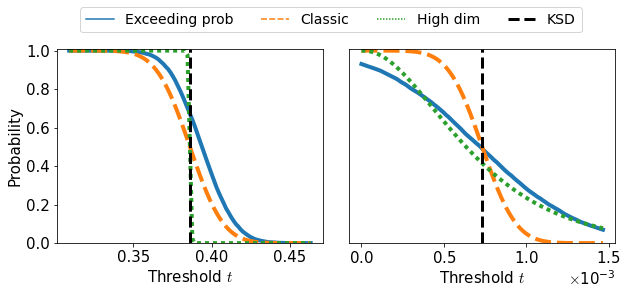

In [393]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.lineplot(
    ax=axes[0],
    data=res_rep_large_n.loc[
        res_rep_large_n.name.isin(["Exceeding prob", "Classic", "High dim"])
    ], 
    x="ts", 
    y="value", 
    hue="name",
    style="name",
    linewidth=4,
)
# statistic expectation
axes[0].axvline(
    hd_limits_rep_large_n.res_analytical["expectation"], color="k", linestyle="--", label="KSD", linewidth=3,
)

axes[0].set_xlabel("Threshold $t$", fontsize=15)
axes[0].set_ylabel("Probability", fontsize=15)
axes[0].set_ylim(0., 1.01)
axes[0].tick_params(labelsize=15)
axes[0].legend(
    fontsize=14, bbox_to_anchor=(2., 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
)

sns.lineplot(
    ax=axes[1],
    data=res_rep.loc[
        res_rep.name.isin(["Exceeding prob", "Classic", "High dim"])
    ], 
    x="ts", 
    y="value", 
    hue="name",
    style="name",
    linewidth=4,
)
# statistic expectation
axes[1].axvline(
    hd_limits_rep.res_analytical["expectation"], color="k", linestyle="--", label="KSD", linewidth=3,
)

axes[1].set_xlabel("Threshold $t$", fontsize=15)
axes[1].set_ylim(0., 1.01)
axes[1].tick_params(labelsize=15)
axes[1].ticklabel_format(style="sci", axis="x", scilimits=(0, 0), useMathText=True)
axes[1].xaxis.get_offset_text().set_fontsize(15)
axes[1].get_yaxis().set_visible(False)
axes[1].legend([],[], frameon=False)

plt.subplots_adjust(
    top=.8,
    wspace=0.1,
)

# plt.savefig(f"../figs/high_dim/power_{STATISTIC}_{KERNEL.__name__}.pdf", bbox_inches="tight")

## Asymmetry

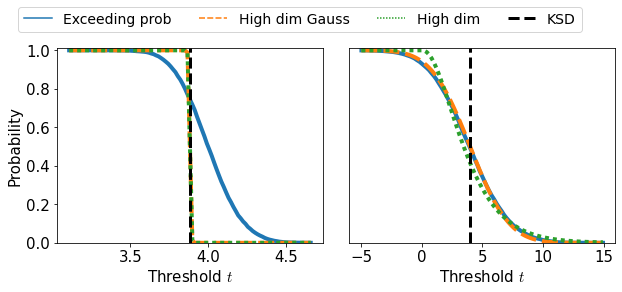

In [194]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.lineplot(
    ax=axes[0],
    data=res_rep_large_n.loc[
        res_rep_large_n.name.isin(["Exceeding prob", "High dim", "High dim Gauss"])
    ], 
    x="ts", 
    y="value", 
    hue="name",
    style="name",
    linewidth=4,
)
# statistic expectation
axes[0].axvline(
    hd_limits_rep_large_n.res_analytical["expectation"], color="k", linestyle="--", label="KSD", linewidth=3,
)

axes[0].set_xlabel("Threshold $t$", fontsize=15)
axes[0].set_ylabel("Probability", fontsize=15)
axes[0].set_ylim(0., 1.01)
axes[0].tick_params(labelsize=15)
axes[0].legend(
    fontsize=14, bbox_to_anchor=(2., 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
)

sns.lineplot(
    ax=axes[1],
    data=res_rep.loc[
        res_rep.name.isin(["Exceeding prob", "High dim", "High dim Gauss"])
    ], 
    x="ts", 
    y="value", 
    hue="name",
    style="name",
    linewidth=4,
)
# statistic expectation
axes[1].axvline(
    hd_limits_rep.res_analytical["expectation"], color="k", linestyle="--", label="KSD", linewidth=3,
)

axes[1].set_xlabel("Threshold $t$", fontsize=15)
axes[1].set_ylim(0., 1.01)
axes[1].tick_params(labelsize=15)
axes[1].xaxis.get_offset_text().set_fontsize(15)
axes[1].get_yaxis().set_visible(False)
axes[1].legend([],[], frameon=False)

plt.subplots_adjust(
    top=.8,
    wspace=0.1,
)

## Distances

In [429]:
# high dim
hd_limits_rep_dims = hd.LimitDistExperimentRepeatedMultiDims(
    empirical_vals_dims_list=statistic_res_list,
    res_analytical=res_analytical,
    dims=dims,
    ns=ns,
    ts=ts,
)
dist_rep = hd_limits_rep_dims.compute_distance(size=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:24<00:00,  8.43s/it]


In [430]:
dist_rep.replace({
    "probs": "Exceeding prob", 
    "cond": "Classic", 
    "full": "High dim Gaussian",
    "mm_full": "High dim Gamma",
}, inplace=True)

In [431]:
# # low dim
# dist_rep_larg_n = hd_limits_rep_large_n.compute_distance()

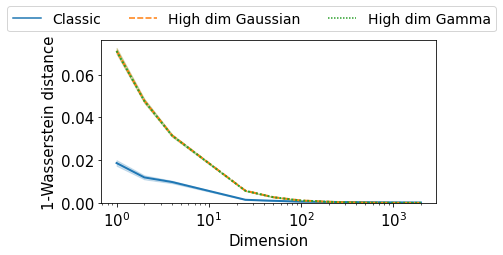

In [438]:
figs, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))

sns.lineplot(
    ax=axes,
    data=dist_rep.loc[dist_rep.name.isin(["Classic", "High dim Gamma", "High dim Gaussian"])], 
    x="dim", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
)

axes.set_xlabel("Dimension", fontsize=15)
axes.set_ylabel("1-Wasserstein distance", fontsize=15)
axes.set_ylim(bottom=0.)
axes.set_xscale("log")
axes.tick_params(labelsize=15)
axes.legend(
    fontsize=14, bbox_to_anchor=(1.2, 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
)
# plt.savefig(f"../figs/high_dim/dist_{STATISTIC}_{KERNEL.__name__}.pdf", bbox_inches="tight")

## Density and ECDF plots

In [199]:
samples_res = hd_limits_rep.sample_all_limits(size=1000)

In [395]:
samples_res.replace({
    "probs": "Dn", 
    "cond": "Classic", 
    "full": "High dim Gaussian",
    "mm_full": "High dim Gamma",
}, inplace=True)

In [396]:
samples_res_ld = hd_limits_rep_large_n.sample_all_limits(size=1000)

In [397]:
samples_res_ld.replace({
    "probs": "Dn", 
    "cond": "Classic", 
    "full": "High dim Gaussian",
    "mm_full": "High dim Gamma",
}, inplace=True)

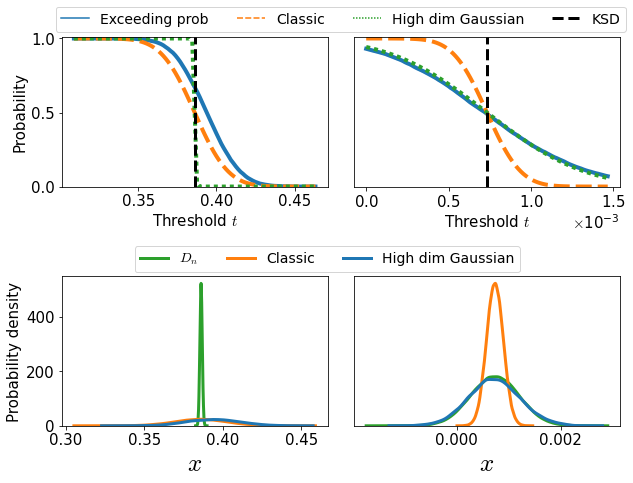

In [440]:
figs, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# 1.ecdf plots
sns.lineplot(
    ax=axes[0][0],
    data=res_rep_large_n.loc[
        res_rep_large_n.name.isin(["Exceeding prob", "Classic", "High dim Gaussian"])
    ], 
    x="ts", 
    y="value", 
    hue="name",
    style="name",
    linewidth=4,
)
# statistic expectation
axes[0][0].axvline(
    hd_limits_rep_large_n.res_analytical["expectation"], color="k", linestyle="--", label="KSD", linewidth=3,
)

axes[0][0].set_xlabel("Threshold $t$", fontsize=15)
axes[0][0].set_ylabel("Probability", fontsize=15)
axes[0][0].set_ylim(0., 1.01)
axes[0][0].tick_params(labelsize=15)
axes[0][0].legend(
    fontsize=14, bbox_to_anchor=(2.15, 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
)

sns.lineplot(
    ax=axes[0][1],
    data=res_rep.loc[
        res_rep.name.isin(["Exceeding prob", "Classic", "High dim Gaussian"])
    ], 
    x="ts", 
    y="value", 
    hue="name",
    style="name",
    linewidth=4,
)
# statistic expectation
axes[0][1].axvline(
    hd_limits_rep.res_analytical["expectation"], color="k", linestyle="--", label="KSD", linewidth=3,
)

axes[0][1].set_xlabel("Threshold $t$", fontsize=15)
axes[0][1].set_ylim(0., 1.01)
axes[0][1].tick_params(labelsize=15)
axes[0][1].ticklabel_format(style="sci", axis="x", scilimits=(0, 0), useMathText=True)
axes[0][1].xaxis.get_offset_text().set_fontsize(15)
axes[0][1].get_yaxis().set_visible(False)
axes[0][1].legend([],[], frameon=False)

plt.subplots_adjust(
    top=.8,
    wspace=0.1,
)

# 2. density plots
hue_order = ["Dn", "Classic", "High dim Gaussian"]
legend_labels = ["$D_n$", "Classic", "High dim Gaussian"]

sns.kdeplot(
    ax=axes[1][0],
    data=samples_res_ld.loc[samples_res_ld.name.isin(hue_order)],
    x="x",
    hue="name",
    hue_order=hue_order,
    linewidth=3,
    common_norm=False,
)

axes[1][0].set_xlabel("$x$", fontsize=25)
axes[1][0].set_ylabel("Probability density", fontsize=15)
axes[1][0].set_ylim(bottom=0.)
axes[1][0].tick_params(labelsize=15)
axes[1][0].legend(
    legend_labels,
    fontsize=14, bbox_to_anchor=(1.75, 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
)

sns.kdeplot(
    ax=axes[1][1],
    data=samples_res.loc[samples_res.name.isin(hue_order)],
    x="x",
    hue="name",
    hue_order=hue_order,
    linewidth=3,
    common_norm=False,
    legend=False,
)

axes[1][1].set_xlabel("$x$", fontsize=25)
axes[1][1].get_yaxis().set_visible(False)
axes[1][1].tick_params(labelsize=15)

plt.subplots_adjust(
#     top=.8,
    wspace=0.1,
    hspace=0.6,
)

plt.savefig(f"../figs/high_dim/power_{STATISTIC}_{KERNEL.__name__}.pdf", bbox_inches="tight")

# Moments vs. dim

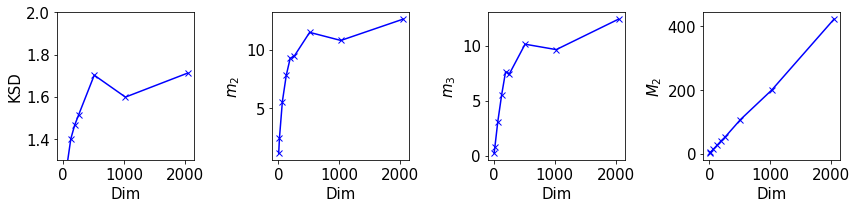

In [21]:
ksd_vals = np.array(res_analytical["ksd"])
m2_vals = np.array(res_analytical["cond_var"])
M2_vals = np.array(res_analytical["full_var"])
m3_vals = np.array(res_analytical["m3"])

m2_d2 = m2_vals / ksd_vals**2
M2_d2 = M2_vals / ksd_vals**2
m3_d3 = m3_vals / ksd_vals**3

figs, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

axes[0].plot(dims, ksd_vals, marker="x", label="$m_2 / D^2$", color="blue")
axes[0].set_xlabel("Dim", fontsize=15)
axes[0].set_ylabel("KSD", fontsize=15)
axes[0].set_ylim(1.3, 2.)
axes[0].tick_params(labelsize=15)

axes[1].plot(dims, m2_vals, marker="x", label="$m_3 / D^3$", color="blue")
axes[1].set_xlabel("Dim", fontsize=15)
axes[1].set_ylabel("$m_2$", fontsize=15)
axes[1].tick_params(labelsize=15)

axes[2].plot(dims, m3_vals, marker="x", label="$m_3 / D^3$", color="blue")
axes[2].set_xlabel("Dim", fontsize=15)
axes[2].set_ylabel("$m_3$", fontsize=15)
axes[2].tick_params(labelsize=15)

axes[3].plot(dims, M2_vals, marker="x", label="$M_2 / D^2$", color="blue")
axes[3].set_xlabel("Dim", fontsize=15)
axes[3].set_ylabel("$M_2$", fontsize=15)
axes[3].tick_params(labelsize=15)

plt.tight_layout()

# figs.savefig("figs/moments_dim.pdf")